Saurin Patel, Rawan Hammad, Anisha Patel

June 8, 2022

Supervised by Dr. Mobasher

The goal of this Jupyter Notebook is to explore various machine learning models and ensembles to test for the best performing model to predict sentiment of tweets from a given dataset. 

Loading Libraries

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import operator

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier as XGBoostClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import neighbors, tree, naive_bayes
from sklearn import decomposition
import time

import seaborn as sns

import re
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
import gensim


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Josep\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Josep\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Josep\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
columns =["target","id","date", "flag", "user","tweet"]

In [3]:
dataset = pd.read_csv("C:/Users/Josep/training.1600000.processed.noemoticon.csv",names = columns, encoding = 'latin-1')

In [4]:
dataset.head()

,target,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   tweet   1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
dataset.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
tweet     0
dtype: int64

In [7]:
sentiment_counts=dataset["target"].value_counts()
sentiment_counts

0    800000
4    800000
Name: target, dtype: int64

Text(0.5, 1.0, 'Number of tweets for each sentiment')

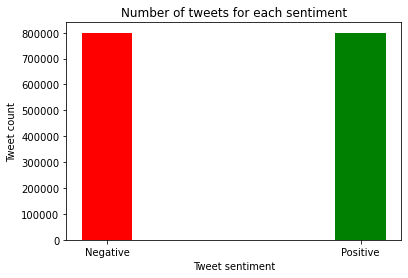

In [8]:
plt.bar(x = sentiment_counts.keys(), 
        height = sentiment_counts.values, color = ['r', 'g'])
plt.xticks([0,4],[ 'Negative', 'Positive'])

plt.xlabel("Tweet sentiment")
plt.ylabel("Tweet count")
plt.title("Number of tweets for each sentiment")


Exploratory analysis on Date

In [9]:
dataset["date"].values

array(['Mon Apr 06 22:19:45 PDT 2009', 'Mon Apr 06 22:19:49 PDT 2009',
       'Mon Apr 06 22:19:53 PDT 2009', ...,
       'Tue Jun 16 08:40:49 PDT 2009', 'Tue Jun 16 08:40:49 PDT 2009',
       'Tue Jun 16 08:40:50 PDT 2009'], dtype=object)

In [10]:
dataset["Day"] = dataset['date'].apply(lambda date: date.split(' ')[0])
dataset["Month"] = dataset['date'].apply(lambda date: date.split(' ')[1])
day_count = dataset["Day"].value_counts()
months_count = dataset["Month"].value_counts()

In [11]:
print(dataset["Month"].unique())

['Apr' 'May' 'Jun']


In [12]:
print(dataset["Day"].unique())

['Mon' 'Tue' 'Fri' 'Sat' 'Sun' 'Wed' 'Thu']


Text(0.5, 1.0, 'Number of tweets for each Month')

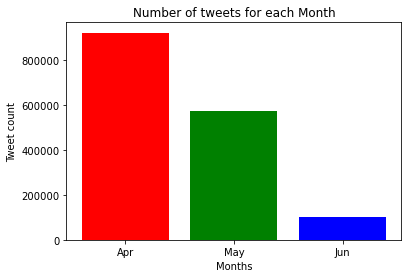

In [13]:
plt.bar(x = dataset["Month"].unique(), 
        height = months_count.values, 
        color = ['r', 'g', 'b'])
plt.xlabel("Months")
plt.ylabel("Tweet count")
plt.title("Number of tweets for each Month")


Text(0.5, 1.0, 'Number of tweets for each Day of a Week')

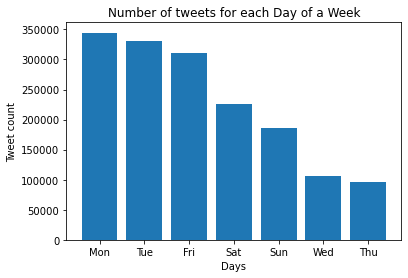

In [14]:
plt.bar(x = dataset["Day"].unique(), 
        height = day_count.values)
plt.xlabel("Days")
plt.ylabel("Tweet count")
plt.title("Number of tweets for each Day of a Week")

In [15]:
dataset = dataset.sample(n=500000)
tweets = list(dataset['tweet'])
sentiment = list(dataset['target'])

Collecting all Hashtags

In [16]:
def hashtag_extract(hashtag):
    hashtags = []
    
    for text in hashtag:
        ht = re.findall(r"#(\w+)", text)
        
        for word in ht:
            ht = []
            word = word.lower()
            word = re.sub(r'[0-9]', '', word)
            word = re.sub(r'\b\w{1,3}\b','', word)
            word = re.sub(' +','', word)
            ht.append(word.strip())
        
        hashtags.append(ht)

    return hashtags

In [17]:
# extracting hashtags from positive tweets
HT_regular = hashtag_extract(dataset['tweet'][dataset['target'] == 4])

# extracting hashtags from negative tweets
HT_negative = hashtag_extract(dataset['tweet'][dataset['target'] == 0])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

In [18]:
dataset["target"].value_counts()

4    250042
0    249958
Name: target, dtype: int64

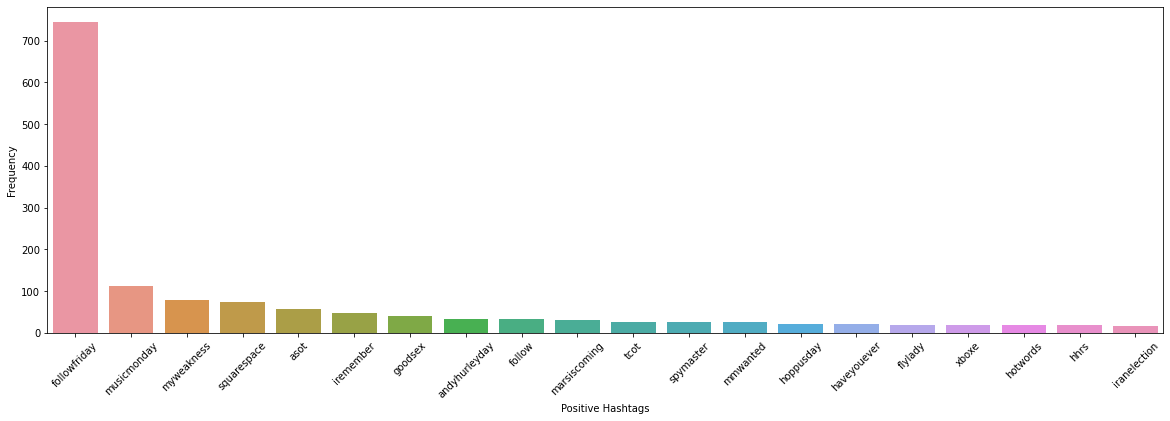

In [19]:
pos_list = nltk.FreqDist(HT_regular)
Pos_hash = pd.DataFrame({'Hashtag': list(pos_list.keys()),
                  'Count': list(pos_list.values())})

# selecting top 20 most frequent hashtags     
# Getting top 21 because the most used has is an empty string
Pos_hash = Pos_hash.nlargest(columns="Count", n = 21)
Pos_hash = Pos_hash[1:21]
plt.figure(figsize=(20,6))
ax = sns.barplot(data=Pos_hash, x= "Hashtag", y = "Count")
ax.set(xlabel = 'Positive Hashtags', ylabel = 'Frequency')
plt.xticks(rotation=45)
plt.show()

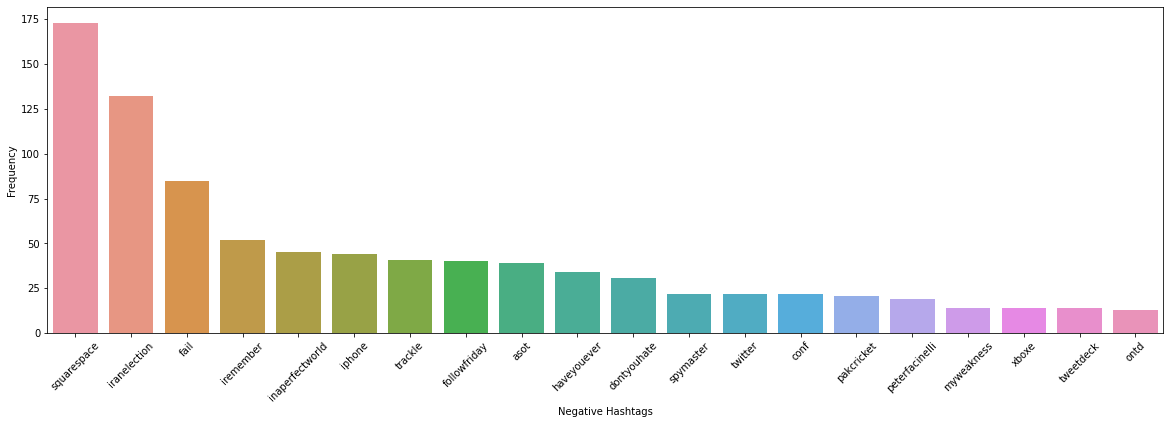

In [20]:
neg_list = nltk.FreqDist(HT_negative)
neg_hash = pd.DataFrame({'Hashtag': list(neg_list.keys()),
                  'Count': list(neg_list.values())})

# selecting top 20 most frequent hashtags     
neg_hash = neg_hash.nlargest(columns="Count", n = 21) 
neg_hash = neg_hash[1:21]
plt.figure(figsize=(20,6))
ax = sns.barplot(data=neg_hash, x= "Hashtag", y = "Count")
ax.set(xlabel ="Negative Hashtags", ylabel = 'Frequency')
plt.xticks(rotation=45)

plt.show()

Exploratory data Analysis on tweets data


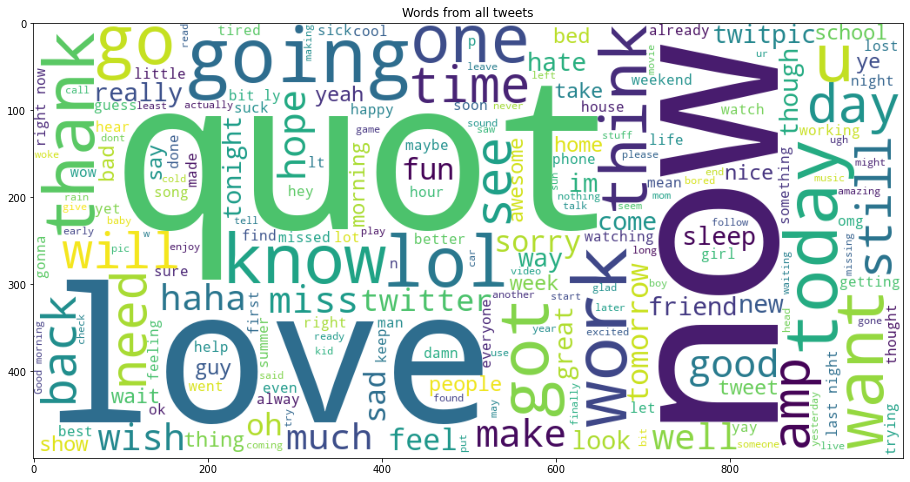

In [21]:
plt.figure(figsize=(20,8))
word_cloud = ""
for row in dataset["tweet"]:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.title("Words from all tweets")
plt.imshow(wordcloud)

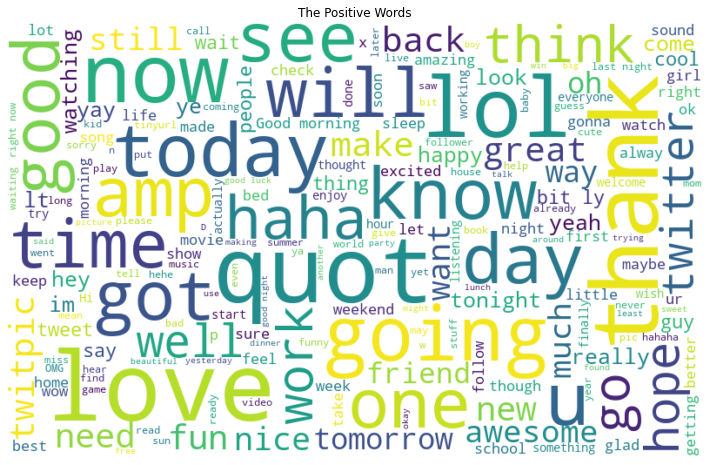

In [22]:
positive_words =' '.join([text for text in dataset['tweet'][dataset['target'] == 4]])

wordcloud = WordCloud(width=800, height=500, background_color ='white', random_state = 0, max_font_size = 110).generate(positive_words)
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Positive Words')
plt.show()

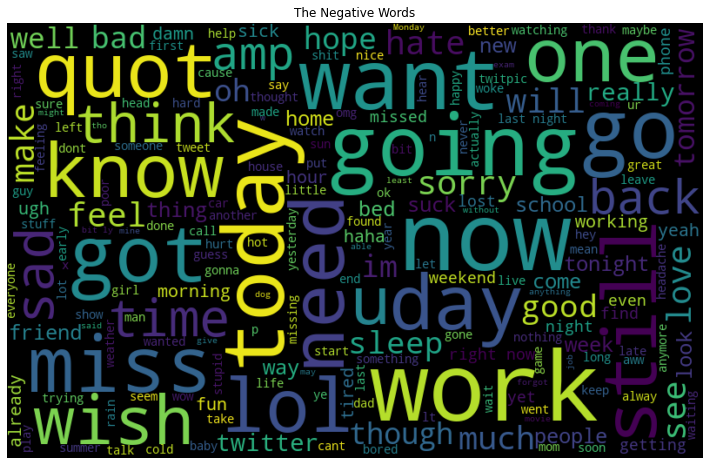

In [23]:
negative_words =' '.join([text for text in dataset['tweet'][dataset['target'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

### Preprocessing of the tweets

In [24]:
stop_words = set(stopwords.words('english'))
stop_words.remove("not")

In [25]:
lemmatizer = WordNetLemmatizer()
porterStemmer = PorterStemmer()

In [26]:
def data_cleaning(data ):
    clean_tweet =[]
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    for tweet in data:
        
        # make all tweets lowercase
        tweet = tweet.lower()
        
        #replace user name(@xxxxx) with an empty string
        tweet = re.sub('@[^\s]+', '', tweet)  
        
        #replace tags(#xxxxx) with an empty string
        tweet = re.sub('#[^\s]+', '', tweet)  
        
        #remove any urls and links
        tweet = re.sub(r"((www\.[^\s]+)|(https?://[^\s]+))", "", tweet)
        
        #remove emojis
        tweet = re.sub(emoji_pattern, "", tweet)
        
        #remove special cahracters
        twet = re.sub('[^a-zA-Z]', '', tweet)
        
        #remove single numberic character
        tweet = re.sub(r'[0-9]', '', tweet)
        
        #remove punctuations
        tweet = re.sub(r'[^\w\s]', '', tweet)
        
        #remove an characters that has length of 1 or 2
        tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
        
        #remove same consecutive letters. eg. heyyyy = hey
        tweet = re.sub(r"(.)\1\1+", r"\1\1", tweet)
        
        # it will remove multiple spaces
        tweet = re.sub(' +', ' ', tweet)

        #an empty string so that we can create a string back from tokenised words
        tweetwords = ''
        
        #tokenising the tweets
        for word in tweet.split():
            
            #removing stop words, lemmetising and stemming the words
            if word not in stop_words:
                root_word = lemmatizer.lemmatize(word)
                tweetwords += (root_word+' ')
                   
        clean_tweet.append(tweetwords)   
    
    return clean_tweet

In [27]:
%%time
processed_tweets=data_cleaning(tweets)

CPU times: total: 24 s
Wall time: 24.1 s


In [28]:
print(processed_tweets[:50])

['chook fun lol started script yet lmao ', 'going miss eddy lot dont get urself killed lad ', 'karls leaving college leaving hospital today ', 'band camp start today ', 'waiting mum got college tired headachey completely drowned unfinished work ', 'rehearsal ', 'well control budget buying new book selecting via supplier website doesnt ', 'listening katy perry make traffic le bad ', 'home ', 'shawdyy finee funn bestie tonighh ', 'woke bird bright note going see jersey boy tnite need nap ', 'wish summer jam day not gonna rain ', 'mitchel mile almost like brother ', 'cant sleep wish still tired ', 'stickamcomlinalrae come talkk started sun pdt ', 'blogger post gone gone gone saddedlyfe ', 'three day school get prepared nutty weekend ', 'missing crowd stay cool amp rest soon ', 'done summary movie review ughh ', 'working supposed day nope not wednesday ', 'circle death ', 'hey kat hon hope good download soon hug sharon ', 'not quite confirmed lot internal shenanigan still eek ', 'gave told

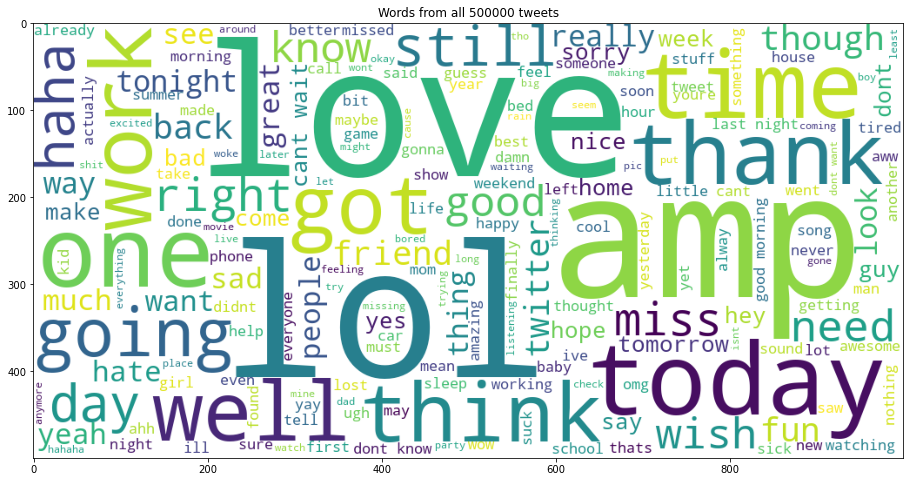

In [29]:
plt.figure(figsize=(20,8))
word_cloud = ""
for row in processed_tweets:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500, background_color ='white',min_font_size = 10).generate(word_cloud)
plt.title("Words from all 500000 tweets")
plt.imshow(wordcloud)

In [30]:
%%time
# tokenizing the words present in the training set
now = time.time()
tokenized_tweet = list(map(lambda x: x.split(), processed_tweets[:500000])) 
# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

word2vec = model_w2v.train(tokenized_tweet, total_examples= len(processed_tweets[:500000]), epochs=20)

CPU times: total: 10min 37s
Wall time: 5min 18s


In [31]:
model_w2v.wv.most_similar(positive = "music")

[('song', 0.5765650272369385),
 ('quothead', 0.5143852233886719),
 ('ycom', 0.5142766833305359),
 ('nerdcore', 0.5049839019775391),
 ('lithium', 0.5044651031494141),
 ('soundsi', 0.5041630864143372),
 ('uplifter', 0.503513753414154),
 ('nbcs', 0.49651649594306946),
 ('grimm', 0.4941481053829193),
 ('funy', 0.490362286567688)]

In [32]:
model_w2v.wv.most_similar(positive = "food")

[('driveins', 0.5252881646156311),
 ('eat', 0.5233196020126343),
 ('diarrhoea', 0.5215107202529907),
 ('salvadorian', 0.5062680840492249),
 ('yummers', 0.501121997833252),
 ('hacienda', 0.49882885813713074),
 ('mexican', 0.4951539933681488),
 ('hardees', 0.4945697784423828),
 ('fettuccine', 0.4936971068382263),
 ('torta', 0.4921347200870514)]

In [33]:
model_w2v.wv.most_similar(negative = "work")

[('ltcauiiogt', 0.11664950102567673),
 ('regarde', 0.06331563740968704),
 ('howdee', 0.04798024892807007),
 ('shorties', 0.02342415228486061),
 ('mistaken', 0.00960646290332079),
 ('annooying', 0.0007961335359141231),
 ('yun', -0.0017815940082073212),
 ('isthanks', -0.003911910578608513),
 ('influence', -0.011710851453244686),
 ('obsession', -0.024577775970101357)]

In [34]:
model_w2v.wv.most_similar(negative = "love")

[('angustia', 0.09750596433877945),
 ('isthanks', 0.06541907042264938),
 ('ltcauiiogt', 0.04091370105743408),
 ('latter', 0.026253020390868187),
 ('shorties', 0.01431435439735651),
 ('med', 0.013402199372649193),
 ('raid', 0.01153137069195509),
 ('vps', 0.008119997568428516),
 ('phi', 0.002489962847903371),
 ('recheck', 0.001897750305943191)]

## Splitting testing and training dataset

In [35]:
x_train, x_test, y_train, y_test = train_test_split (processed_tweets, dataset.iloc[:,0],test_size =0.1, random_state = 33)

In [36]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [37]:
print("x_train:",x_train.shape)
print("x_test: ",x_test.shape)
print("y_train:",y_train.shape)
print("y_test: ",y_test.shape)


x_train: (450000,)
x_test:  (50000,)
y_train: (450000,)
y_test:  (50000,)


In [38]:
print(y_train)

[0 4 4 ... 0 0 4]


# TF-IDF Vectiorising

In [39]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)

In [40]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(x_test)
print(f'Vectoriser fitted to Testing Dataset.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted to Testing Dataset.
No. of feature_words:  248466


C:\Users\Josep\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [41]:
x_train = vectoriser.transform(x_train)
x_test  = vectoriser.transform(x_test)
print(f'Data Transformed.')

Data Transformed.


In [42]:
x_train.shape

(450000, 248466)

# Building a Model

Our dataset is not biased. It has an equal number of both positive and negatives sentiments, with no neutral values. We will use the 450,000 tweets to train our models, explore their metrics, then predict sentiment using the best two models

# Model Evaluation

In [43]:
def model_Evaluate(model):
    model_name = str(type(model).__name__)

    print("")
    print("=====================================================")
    print("Testing " + model_name)
    now = time.time()
   
    predictions = model.predict(x_test)
    print("Predicting time {0}s".format(time.time() - now))

    precision = precision_score(y_test, predictions, average=None, pos_label=None)
    recall = recall_score(y_test, predictions, average=None, pos_label=None)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average=None, pos_label=None)
    print("====================== Results ======================")
    print("=============== Classification Report ===============")
    print(classification_report(y_test, predictions))
    print("================== Confusion Matrix =================")
    cf_matrix = confusion_matrix(y_test, predictions)
    print(cf_matrix)
    print("=====================================================")

    print("         Negative     Positive")
    print("F1       " + str(f1))
    print("Precision" + str(precision))
    print("Recall   " + str(recall))
    print("Accuracy " + str(accuracy))
    print("=====================================================")

    return precision, recall, accuracy, f1

In [44]:
def cross_validation(classifier, X_train, y_train):
    print("=====================================================")
    classifier_name = str(type(classifier).__name__)
    now = time.time()
    print("Crossvalidating " + classifier_name + "...")
    accuracy = [cross_val_score(classifier, X_train, y_train, cv=8, n_jobs=-1)]
    print("Crosvalidation completed in {0}s".format(time.time() - now))
    print("Accuracy: " + str(accuracy[0]))
    print("Average accuracy: " + str(np.array(accuracy[0]).mean()))
    print("=====================================================")
    return accuracy

# Logistic Regression

In [175]:
%%time
LR_basemodel = LogisticRegression()
LR_basemodel.fit(x_train, y_train)
model_Evaluate(LR_basemodel)


Testing LogisticRegression
Predicting time 0.003471851348876953s
====================== Results ======================
=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.83      0.74      0.78     24905
           1       0.77      0.85      0.80     25095

    accuracy                           0.79     50000
   macro avg       0.80      0.79      0.79     50000
weighted avg       0.80      0.79      0.79     50000

================== Confusion Matrix =================
[[18391  6514]
 [ 3879 21216]]
         Negative     Positive
F1       [0.77969263 0.80325603]
Precision[0.82581949 0.76509196]
Recall   [0.7384461  0.84542738]
Accuracy 0.79214
CPU times: total: 57.4 s
Wall time: 7.35 s


C:\Users\Josep\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(array([0.82581949, 0.76509196]),
 array([0.7384461 , 0.84542738]),
 0.79214,
 array([0.77969263, 0.80325603]))

In [176]:
LR_acc = cross_validation(LR_basemodel, x_train, y_train)

Crossvalidating LogisticRegression...
Crosvalidation completed in 22.846740245819092s
Accuracy: [0.79299556 0.78999111 0.79326222 0.79395556 0.79176889 0.79168
 0.79580444 0.79262222]
Average accuracy: 0.7927599999999999


Hyper parameter tuning for Logistic regression


In [177]:
%%time
LR_model = LogisticRegression()
penalty = ['l1','l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle = True)
grid_search = GridSearchCV(estimator=LR_model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train, y_train)

C:\Users\Josep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Josep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Josep\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Josep\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Value

CPU times: total: 1min
Wall time: 2min 10s


C:\Users\Josep\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [178]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.792364 using {'C': 1.0, 'penalty': 'l2'}


In [179]:
%%time
LR_tuned = LogisticRegression(C= 1.0, penalty = 'l2')
LR_tuned.fit(x_train, y_train)
model_Evaluate(LR_tuned)


Testing LogisticRegression
Predicting time 0.0024809837341308594s
====================== Results ======================
=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.83      0.74      0.78     24905
           1       0.77      0.85      0.80     25095

    accuracy                           0.79     50000
   macro avg       0.80      0.79      0.79     50000
weighted avg       0.80      0.79      0.79     50000

================== Confusion Matrix =================
[[18391  6514]
 [ 3879 21216]]
         Negative     Positive
F1       [0.77969263 0.80325603]
Precision[0.82581949 0.76509196]
Recall   [0.7384461  0.84542738]
Accuracy 0.79214
CPU times: total: 60 s
Wall time: 8.02 s


C:\Users\Josep\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(array([0.82581949, 0.76509196]),
 array([0.7384461 , 0.84542738]),
 0.79214,
 array([0.77969263, 0.80325603]))

In [180]:
LR_acc = cross_validation(LR_tuned, x_train, y_train)

Crossvalidating LogisticRegression...
Crosvalidation completed in 21.415833950042725s
Accuracy: [0.79299556 0.78999111 0.79326222 0.79395556 0.79176889 0.79168
 0.79580444 0.79262222]
Average accuracy: 0.7927599999999999


We just decided to go with use Logistic Regression with l2 penalty after tuning, and C = 1.0 which gave an accuracy value of 0.79244. 

# Bernoulli's Naive Bayes

In [51]:
%%time
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(x_train, y_train)
model_Evaluate(BNBmodel)


Testing BernoulliNB
Predicting time 0.017856121063232422s
====================== Results ======================
=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.79      0.76      0.78     24905
           4       0.77      0.80      0.79     25095

    accuracy                           0.78     50000
   macro avg       0.78      0.78      0.78     50000
weighted avg       0.78      0.78      0.78     50000

================== Confusion Matrix =================
[[19048  5857]
 [ 4975 20120]]
         Negative     Positive
F1       [0.77861347 0.78790727]
Precision[0.7929068  0.77453132]
Recall   [0.76482634 0.80175334]
Accuracy 0.78336
CPU times: total: 234 ms
Wall time: 231 ms


(array([0.7929068 , 0.77453132]),
 array([0.76482634, 0.80175334]),
 0.78336,
 array([0.77861347, 0.78790727]))

In [52]:
nb_acc = cross_validation(BNBmodel, x_train, y_train)

Crossvalidating BernoulliNB...
Crosvalidation completed in 0.5499567985534668s
Accuracy: [0.77912889 0.77790222 0.77966222 0.77863111 0.77795556 0.77720889
 0.78069333 0.77900444]
Average accuracy: 0.7787733333333333


# SVM

In [83]:
%%time
SVCmodel = svm.SVC()
SVCmodel.fit(x_train, y_train)

SVC()

In [ ]:
model_Evaluate(SVCmodel)


Testing SVC


In [ ]:
%%time
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(x_train[:200000], y_train[:200000])

In [ ]:
# this shows the best parameters
clf_fit.best_params_

In [ ]:
%%time
SVC_tuned = svm.SVC()
SVC_tuned.fit(x_train, y_train)

In [ ]:
model_Evaluate(SVC_tuned)

# Decision Tree

In [53]:
%%time
DTmodel = tree.DecisionTreeClassifier()
DTmodel.fit(x_train, y_train)

CPU times: total: 11min 59s
Wall time: 11min 59s


DecisionTreeClassifier()

In [54]:
model_Evaluate(DTmodel)


Testing DecisionTreeClassifier
Predicting time 0.13689613342285156s
====================== Results ======================
=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.73      0.71      0.72     24905
           4       0.72      0.73      0.73     25095

    accuracy                           0.72     50000
   macro avg       0.72      0.72      0.72     50000
weighted avg       0.72      0.72      0.72     50000

================== Confusion Matrix =================
[[17763  7142]
 [ 6700 18395]]
         Negative     Positive
F1       [0.71961595 0.72661558]
Precision[0.72611699 0.72032737]
Recall   [0.71323028 0.73301454]
Accuracy 0.72316


(array([0.72611699, 0.72032737]),
 array([0.71323028, 0.73301454]),
 0.72316,
 array([0.71961595, 0.72661558]))

# KNN

In [55]:
%%time
knnmodel = neighbors.KNeighborsClassifier(3, weights='distance')
knnmodel.fit(x_train, y_train)

CPU times: total: 31.2 ms
Wall time: 35.2 ms


KNeighborsClassifier(n_neighbors=3, weights='distance')

In [62]:
%%time
accuracy = knnmodel.score(x_test, y_test)
print(accuracy)

0.5905
CPU times: total: 4min 52s
Wall time: 4min 52s


In [63]:
model_Evaluate(knnmodel)


Testing KNeighborsClassifier
Predicting time 292.9539067745209s
====================== Results ======================
=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.55      0.93      0.69     24905
           4       0.78      0.25      0.38     25095

    accuracy                           0.59     50000
   macro avg       0.67      0.59      0.54     50000
weighted avg       0.67      0.59      0.54     50000

================== Confusion Matrix =================
[[23148  1757]
 [18718  6377]]
         Negative     Positive
F1       [0.6933549  0.38382136]
Precision[0.55290689 0.78399312]
Recall   [0.92945192 0.25411437]
Accuracy 0.5905


(array([0.55290689, 0.78399312]),
 array([0.92945192, 0.25411437]),
 0.5905,
 array([0.6933549 , 0.38382136]))

In [64]:
nb_acc = cross_validation(knnmodel, x_train, y_train)

Crossvalidating KNeighborsClassifier...
Crosvalidation completed in 1139.7447257041931s
Accuracy: [0.61872    0.64499556 0.65013333 0.64604444 0.64826667 0.64741333
 0.64798222 0.6472    ]
Average accuracy: 0.6438444444444444


# Using Rocchio method of KNN, which is Nearest Centroid

In [65]:
%%time
from sklearn.neighbors import NearestCentroid
nearest_model = NearestCentroid()
nearest_model.fit(x_train, y_train)
NearestCentroid()

CPU times: total: 93.8 ms
Wall time: 93.2 ms


NearestCentroid()

In [66]:
model_Evaluate(nearest_model)


Testing NearestCentroid
Predicting time 0.011903524398803711s
====================== Results ======================
=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.75      0.71      0.73     24905
           4       0.73      0.77      0.75     25095

    accuracy                           0.74     50000
   macro avg       0.74      0.74      0.74     50000
weighted avg       0.74      0.74      0.74     50000

================== Confusion Matrix =================
[[17710  7195]
 [ 5876 19219]]
         Negative     Positive
F1       [0.73044482 0.74623852]
Precision[0.75086916 0.72760657]
Recall   [0.71110219 0.76584977]
Accuracy 0.73858


(array([0.75086916, 0.72760657]),
 array([0.71110219, 0.76584977]),
 0.73858,
 array([0.73044482, 0.74623852]))

In [61]:
nb_acc = cross_validation(nearest_model, x_train, y_train)

Crossvalidating NearestCentroid...
Crosvalidation completed in 0.6110732555389404s
Accuracy: [0.74293333 0.73870222 0.74227556 0.73900444 0.74062222 0.74037333
 0.74088889 0.73960889]
Average accuracy: 0.7405511111111112


# XGBoost

In [67]:
def xgb_model_Evaluate(model):
    model_name = str(type(model).__name__)

    print("")
    print("=====================================================")
    print("Testing " + model_name)
    now = time.time()
   
    predictions = model.predict(x_test)
    print("Predicting time {0}s".format(time.time() - now))

    precision = precision_score(Test_y, predictions, average=None, pos_label=None)
    recall = recall_score(Test_y, predictions, average=None, pos_label=None)
    accuracy = accuracy_score(Test_y, predictions)
    f1 = f1_score(Test_y, predictions, average=None, pos_label=None)
    print("====================== Results ======================")
    print("=============== Classification Report ===============")
    print(classification_report(Test_y, predictions))
    print("================== Confusion Matrix =================")
    cf_matrix = confusion_matrix(Test_y, predictions)
    print(cf_matrix)
    print("=====================================================")

    print("         Negative     Positive")
    print("F1       " + str(f1))
    print("Precision" + str(precision))
    print("Recall   " + str(recall))
    print("Accuracy " + str(accuracy))
    print("======================================================")

    return precision, recall, accuracy, f1

In [68]:
Train_y = y_train
Test_y = y_test
Train_y[np.where(Train_y ==4)] =1
Test_y[np.where(Test_y ==4)] =1

In [69]:
Test_y

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [70]:
%%time
xgb_model = XGBoostClassifier()
xgb_model.fit(x_train, Train_y)

C:\Users\Josep\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:10:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: total: 4min 13s
Wall time: 18.2 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [71]:
xgb_model_Evaluate(xgb_model)


Testing XGBClassifier
Predicting time 0.06993579864501953s
====================== Results ======================
=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.80      0.62      0.70     24905
           1       0.69      0.84      0.76     25095

    accuracy                           0.73     50000
   macro avg       0.75      0.73      0.73     50000
weighted avg       0.75      0.73      0.73     50000

================== Confusion Matrix =================
[[15511  9394]
 [ 3894 21201]]
         Negative     Positive
F1       [0.70011284 0.76139343]
Precision[0.79933007 0.69295637]
Recall   [0.62280667 0.84482965]
Accuracy 0.73424


(array([0.79933007, 0.69295637]),
 array([0.62280667, 0.84482965]),
 0.73424,
 array([0.70011284, 0.76139343]))

In [72]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                results['mean_test_score'][candidate],
                results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [75]:
def best_fit(x_train, y_train, n_iter):
    parameters = {
        "n_estimators":[103,201, 403],
        "max_depth":[3,10,15, 30],
        "objective":["multi:softmax","binary:logistic"],
        "learning_rate":[0.05, 0.1, 0.15, 0.3]
    }

    rand_search = RandomizedSearchCV(XGBoostClassifier(),param_distributions=parameters,
                                     n_iter=n_iter,scoring="accuracy",
                                     n_jobs=-1,cv=8)

    now = time.time()
    rand_search.fit(x_train, y_train)
    report(rand_search.cv_results_, 10)
    print("Search took: " + str(time.time() - now))

In [76]:
%%time
best_fit(x_train, Train_y , n_iter=3)

C:\Users\Josep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
16 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Josep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Josep\anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
    return f(**kwargs)
  File "C:\Users\Josep\anaconda3\lib\site-packages\xgboost\sklearn.py", line 1250, in fit
    self._Booster = train(
  File "C:\Users\Josep\anaconda3\lib\site-packages\xgboost\training.py", line 18

[12:51:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model with rank: 1
Mean validation score: 0.733 (std: 0.002)
Parameters: {'objective': 'binary:logistic', 'n_estimators': 103, 'max_depth': 10, 'learning_rate': 0.1}

Model with rank: 2
Mean validation score: nan (std: nan)
Parameters: {'objective': 'multi:softmax', 'n_estimators': 201, 'max_depth': 10, 'learning_rate': 0.3}

Model with rank: 3
Mean validation score: nan (std: nan)
Parameters: {'objective': 'multi:softmax', 'n_estimators': 403, 'max_depth': 3, 'learning_rate': 0.15}

Search took: 288.69189953804016
CPU times: total: 8min 58s
Wall time: 4min 48s


Running XGBoost using the best parameters ranked 1 above

In [79]:
%%time
xgb_model_tuned = XGBoostClassifier(objective = 'binary:logistic', n_estimators = 103, max_depth = 10, learning_rate = 0.1)
xgb_model_tuned.fit(x_train, Train_y)

C:\Users\Josep\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:02:04] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: total: 7min 51s
Wall time: 32.9 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=103, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [81]:
xgb_model_Evaluate(xgb_model_tuned)


Testing XGBClassifier
Predicting time 0.09820747375488281s
====================== Results ======================
=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.80      0.59      0.68     24905
           1       0.68      0.85      0.75     25095

    accuracy                           0.72     50000
   macro avg       0.74      0.72      0.72     50000
weighted avg       0.74      0.72      0.72     50000

================== Confusion Matrix =================
[[14737 10168]
 [ 3761 21334]]
         Negative     Positive
F1       [0.67907748 0.75389155]
Precision[0.79668072 0.67722684]
Recall   [0.59172857 0.85012951]
Accuracy 0.72142


(array([0.79668072, 0.67722684]),
 array([0.59172857, 0.85012951]),
 0.72142,
 array([0.67907748, 0.75389155]))

# Random Forest

In [82]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 33, n_jobs = -1, n_estimators= 100)
rf.fit(x_train, y_train)

CPU times: total: 12h 12min 1s
Wall time: 53min 2s


RandomForestClassifier(n_jobs=-1, random_state=33)

In [83]:
model_Evaluate(rf)


Testing RandomForestClassifier
Predicting time 5.249809741973877s
====================== Results ======================
=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.78      0.76      0.77     24905
           1       0.77      0.79      0.78     25095

    accuracy                           0.77     50000
   macro avg       0.77      0.77      0.77     50000
weighted avg       0.77      0.77      0.77     50000

================== Confusion Matrix =================
[[18884  6021]
 [ 5345 19750]]
         Negative     Positive
F1       [0.76867342 0.77655015]
Precision[0.77939659 0.76636529]
Recall   [0.75824132 0.78700936]
Accuracy 0.77268


(array([0.77939659, 0.76636529]),
 array([0.75824132, 0.78700936]),
 0.77268,
 array([0.76867342, 0.77655015]))

In [84]:
%%time
# parameter grid
param_grid = {
    'n_estimators': [100, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
 
# grid search CV
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid)
CV_rf.fit(x_train, y_train)

CPU times: total: 41min 28s
Wall time: 31min


GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=33),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 300]})

In [85]:
# this shows the best parameters
CV_rf.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 300}

In [86]:
%%time
# now run the model using the best params;
# in the example below, its auto, 200, 8, and gini
rf_tuned = RandomForestClassifier(max_features='auto', n_estimators= 300, max_depth=8, criterion='gini')
# fit the model
rf_model = rf_tuned.fit(x_train, y_train)

CPU times: total: 2min
Wall time: 2min


In [87]:
model_Evaluate(rf_tuned)


Testing RandomForestClassifier
Predicting time 1.1968393325805664s
====================== Results ======================
=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.75      0.67      0.71     24905
           1       0.70      0.78      0.74     25095

    accuracy                           0.72     50000
   macro avg       0.73      0.72      0.72     50000
weighted avg       0.73      0.72      0.72     50000

================== Confusion Matrix =================
[[16634  8271]
 [ 5525 19570]]
         Negative     Positive
F1       [0.70686724 0.73938341]
Precision[0.75066564 0.70292015]
Recall   [0.66789801 0.77983662]
Accuracy 0.72408


(array([0.75066564, 0.70292015]),
 array([0.66789801, 0.77983662]),
 0.72408,
 array([0.70686724, 0.73938341]))

## Results

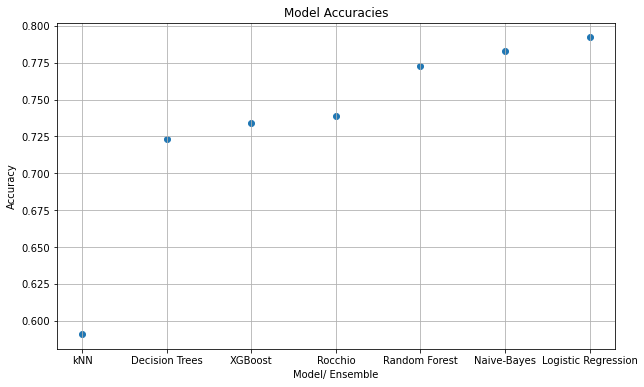

In [183]:
# creating dictionaries of accuracies and runtimes
accuracies = {"XGBoost": [0.73424], 
        "Logistic Regression": [0.79214],
        "Random Forest": [0.77268], 
        "kNN": [0.591], 
        "Rocchio": [0.739], 
        "Decision Trees": [0.723], 
        "Naive-Bayes": [0.783]}

runtimes = {"XGBoost": [18.2], 
        "Logistic Regression": [7.35],
        "Random Forest": [3182], 
        "kNN": [0.0352], 
        "Rocchio": [0.0932], 
        "Decision Trees": [719], 
        "Naive-Bayes": [0.231]}

plt.figure(figsize=(10,6))

accuracy = sorted(accuracies.items(), key=operator.itemgetter(1))

x, y = zip(*accuracy) # unpack a list of pairs into two tuples

plt.xlabel('Model/ Ensemble')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.scatter(x, y)

plt.grid()
plt.show()

Per the graph above, the best performing models would be logistic regression, followed by Naive-Bayes and Random Forest.

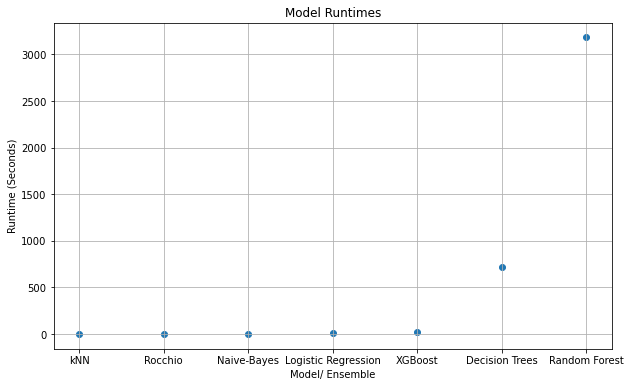

In [184]:
plt.figure(figsize=(10,6))

runtime = sorted(runtimes.items(), key=operator.itemgetter(1))

x, y = zip(*runtime) # unpack a list of pairs into two tuples

plt.xlabel('Model/ Ensemble')
plt.ylabel('Runtime (Seconds)')
plt.title('Model Runtimes')
plt.scatter(x, y)

plt.grid()
plt.show()

Per the plot above, we can see that Random Forest took the longest to run, with kNN being the fastest. We did try to run SVM but it took too long for our machines to handle. However, SVM could have easily exceeded 10+ hours and was ruled as too inefficient to consider in this assessment.

Now let's predict using the top 2 best performing models, which are Logistic Regression and Naive Bayes. 

In [185]:
# prediction function
def predict(vectoriser, model, text):
    txt_dat = vectoriser.transform(data_cleaning(text))
    sentiment = model.predict(txt_dat)      

    dat = []
    for text, pred in zip(text, sentiment):
        dat.append((text,pred))
        
    prediction = pd.DataFrame(dat, columns = ['text','sentiment'])
    print("\n")
    
    return prediction

In [154]:
dataset[["tweet", "target"]].head(10)

,tweet,target
520638,@sydjfk Chook no fun on ur own... lol u s...,0
201231,is going to miss Eddy lots!! dont get urself k...,0
267392,Karl's leaving for college and I'm leaving for...,0
1465452,Band Camp starts today!!!,4
605392,Just waiting on my mum now... Got to go to co...,0
122001,@twistedbarbie No i HAVE rehearsal,0
444319,@The_Librain well I do control budget for buyi...,0
1258150,Listening to Katy Perry makes traffic less bad...,4
105599,@ginogreen home,0
1514797,shawdyy fineee . had funn w/ bestie tonighhh,4


Predictions using the tuned version of Logistic Regression:

In [156]:
for i in range(0,10):
    print(predict(vectoriser, LR_tuned, [dataset["tweet"].iat[i]]))



                                                text  sentiment
0  @sydjfk Chook no fun on ur own...      lol u s...          4


                                                text  sentiment
0  is going to miss Eddy lots!! dont get urself k...          0


                                                text  sentiment
0  Karl's leaving for college and I'm leaving for...          0


                         text  sentiment
0  Band Camp starts today!!!           4


                                                text  sentiment
0  Just waiting on  my mum now... Got to go to co...          0


                                  text  sentiment
0  @twistedbarbie No  i HAVE rehearsal          4


                                                text  sentiment
0  @The_Librain well I do control budget for buyi...          0


                                                text  sentiment
0  Listening to Katy Perry makes traffic less bad...          0


               text  sentiment
0

In [157]:
predict(vectoriser, LR_tuned, ["Love is love"])

,text,sentiment
0,Love is love,4


In [158]:
predict(vectoriser, LR_tuned, ["I hate you"])

,text,sentiment
0,I hate you,0


In [159]:
predict(vectoriser, LR_tuned, ["I'm so happy"])

,text,sentiment
0,I'm so happy,4


In [160]:
predict(vectoriser, LR_tuned, ["To be or not to be"])

,text,sentiment
0,To be or not to be,0


In [161]:
predict(vectoriser, LR_tuned, ["cry me a river"])

,text,sentiment
0,cry me a river,0


Now let's predict using the second best, Naive Bayes:

In [162]:
for i in range(0,10):
    print(predict(vectoriser, BNBmodel, [dataset["tweet"].iat[i]]))



                                                text  sentiment
0  @sydjfk Chook no fun on ur own...      lol u s...          4


                                                text  sentiment
0  is going to miss Eddy lots!! dont get urself k...          0


                                                text  sentiment
0  Karl's leaving for college and I'm leaving for...          0


                         text  sentiment
0  Band Camp starts today!!!           4


                                                text  sentiment
0  Just waiting on  my mum now... Got to go to co...          0


                                  text  sentiment
0  @twistedbarbie No  i HAVE rehearsal          4


                                                text  sentiment
0  @The_Librain well I do control budget for buyi...          0


                                                text  sentiment
0  Listening to Katy Perry makes traffic less bad...          4


               text  sentiment
0

In [163]:
predict(vectoriser, LR_tuned, ["Love is love"])

,text,sentiment
0,Love is love,4


In [164]:
predict(vectoriser, LR_tuned, ["I hate you"])

,text,sentiment
0,I hate you,0


In [165]:
predict(vectoriser, LR_tuned, ["I'm so happy"])

,text,sentiment
0,I'm so happy,4


In [166]:
predict(vectoriser, LR_tuned, ["To be or not to be"])

,text,sentiment
0,To be or not to be,0


In [167]:
predict(vectoriser, LR_tuned, ["cry me a river"])

,text,sentiment
0,cry me a river,0
